In [3]:
import sys

custom_module_path = "/home/rebeccaz/Github/vampires_calibration"
sys.path.append(custom_module_path)

import instruments as inst
import copy
import numpy as np
import json

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [5]:
file_path = "/home/rebeccaz/Github/vampires_calibration/data/20230914_processed_table.csv"
wavelength_string = 610
obs_mode = "MBI"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values)∂
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list)

print(interleaved_stds[0])

Interleaved Values
Length:  320
[ 3.4900e+02  3.8265e+03 -1.3990e+03  3.7120e+03 -3.6900e+02  3.8085e+03
 -7.8100e+02  3.6530e+03 -1.6115e+03  3.7675e+03  4.3550e+02  3.7490e+03
 -2.8025e+03  3.8620e+03  1.7140e+03  3.4975e+03 -3.2370e+03  3.8785e+03
  2.5660e+03  3.4885e+03 -2.9360e+03  3.8120e+03  2.6200e+03  3.5130e+03
 -2.4225e+03  3.7445e+03  2.2160e+03  3.5575e+03 -2.2800e+03  3.7500e+03
  1.9065e+03  3.6030e+03  9.5900e+02  3.6395e+03 -1.6105e+03  3.7825e+03
  1.2225e+03  3.5925e+03 -2.1965e+03  3.7770e+03  5.2500e+02  3.7915e+03
 -1.6330e+03  3.7250e+03 -6.0200e+02  3.7855e+03 -4.1500e+02  3.7740e+03
 -1.7700e+03  3.8420e+03  8.0700e+02  3.6225e+03 -2.2155e+03  3.8375e+03
  1.6300e+03  3.5360e+03 -2.0300e+03  3.7690e+03  1.8360e+03  3.5445e+03
 -1.7095e+03  3.7030e+03  1.6790e+03  3.5700e+03  1.0275e+03  3.5875e+03
 -1.1395e+03  3.7320e+03  2.1480e+03  3.5045e+03 -2.5835e+03  3.8030e+03
  2.2845e+03  3.5150e+03 -3.1410e+03  3.8350e+03  1.4360e+03  3.6010e+03
 -2.6170e+03  3.793

In [6]:
%%timeit

import copy


copy.deepcopy(interleaved_values)

1.51 µs ± 7.07 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [3]:
# Loading in previous fit from vampires_calibration
filename = "625-50_restrictive_HWP_FLC_no_IMR_offset_fixed_EM_gain_no_IMR_or_IMR_retardance_constraints_with_dichroic_best_fit_old_fit_values.txt"
with open(filename, "r") as f:
    past_fit = json.load(f)

print(past_fit)

theta_pol = past_fit["lp"]["theta"]
delta_HWP = past_fit["hwp"]["phi"] 
offset_HWP = past_fit["hwp"]["delta_theta"]
delta_derot = past_fit["image_rotator"]["phi"] 
delta_opts = past_fit["optics"]["phi"]
epsilon_opts = past_fit["optics"]["epsilon"]
rot_opts = past_fit["optics"]["theta"]
delta_FLC = past_fit["flc"]["phi"] 
rot_FLC = past_fit["flc"]["delta_theta"]
em_gain = 1.230573943788524 # from EM gain measurements

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits Google Sheets - having zeros for angles that're too large
# theta_pol = 0
# delta_HWP = 0.451  # Add your actual delta_HWP value
# offset_HWP = -2.642  # Add your actual offset_HWP value
# delta_derot = 0.32  # Add your actual delta_derot value
# offset_derot = 0  # Add your actual offset_derot value
# delta_opts = 0  # Add your actual delta_opts value
# epsilon_opts = 0  # Add your actual epsilon_opts value
# rot_opts = 0  # Add your actual rot_opts value
# delta_FLC = 0.5  # Add your actual delta_FLC value
# rot_FLC = 0  # Add your actual rot_FLC value
# em_gain = 1.2  # Add your actual em_gain value

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary
system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 0, "epsilon": 0, "theta" : 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": delta_derot, "theta": 0, "delta_theta": 0},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        }
    }
}

{'dichroic': {'phi': 0.30872304463963207, 'epsilon': 0.010945621474919988, 'theta': 1.8315213575483158}, 'flc': {'phi': 3.318462559843585, 'delta_theta': 1.798029718547543}, 'optics': {'phi': -0.8083964583195624, 'epsilon': 0.013895280106864007, 'theta': 18.01712022177098}, 'image_rotator': {'phi': 1.365065666004961}, 'hwp': {'phi': 2.752521179595714, 'delta_theta': -1.9748257333612886}, 'lp': {'theta': -0.15074376412465285}}


In [4]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[ 0.59840979  0.5984015  -0.00314879  0.        ]
 [ 0.59840979  0.5984015  -0.00314879  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


# Step 4: Creating a dictionary of p0 starting guesses

{'dichroic': {'phi': 0.30872304463963207, 'epsilon': 0.010945621474919988, 'theta': 1.8315213575483158}, 'flc': {'phi': 3.318462559843585, 'delta_theta': 1.798029718547543}, 'optics': {'phi': -0.8083964583195624, 'epsilon': 0.013895280106864007, 'theta': 18.01712022177098}, 'image_rotator': {'phi': 1.365065666004961}, 'hwp': {'phi': 2.752521179595714, 'delta_theta': -1.9748257333612886}, 'lp': {'theta': -0.15074376412465285}}
logl value: 9740.736435939649


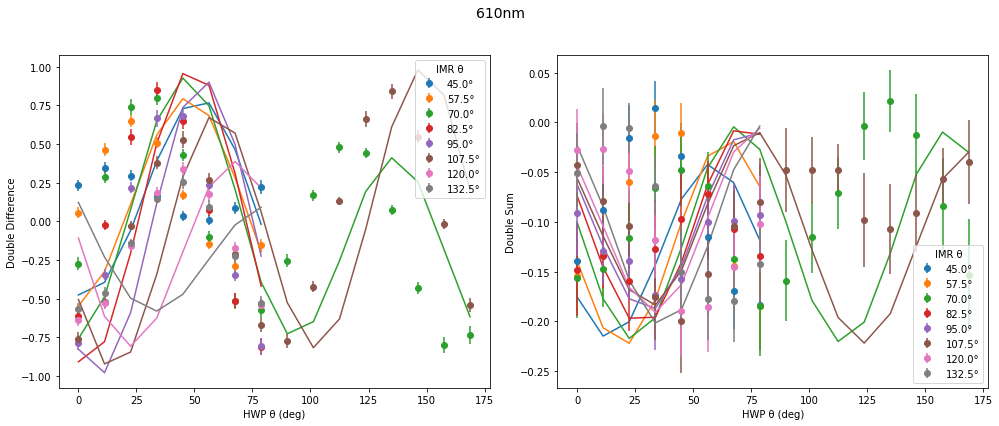

In [5]:
# Fittin for all parameters
p0 = past_fit

print(p0)

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)

# Step 5: Running minimize_system_Mueller_matrix iteratively

Before p0: {'dichroic': {'phi': 0.30872304463963207, 'epsilon': 0.010945621474919988, 'theta': 1.8315213575483158}, 'flc': {'phi': 3.318462559843585, 'delta_theta': 1.798029718547543}, 'optics': {'phi': -0.8083964583195624, 'epsilon': 0.013895280106864007, 'theta': 18.01712022177098}, 'image_rotator': {'phi': 1.365065666004961}, 'hwp': {'phi': 2.752521179595714, 'delta_theta': -1.9748257333612886}, 'lp': {'theta': -0.15074376412465285}}
Iteration #: 1
logl_value: 273.3936771701265
Best Fit Parameters: [ 1.77095592e-01  1.39376911e-06 -2.54782658e+01  3.76991118e+00
 -4.93913709e+00  7.23379146e-01  1.69832815e-02 -4.75351249e+00
  1.38780656e+00  2.84746219e+00  1.90380193e+00 -1.97663554e+00]


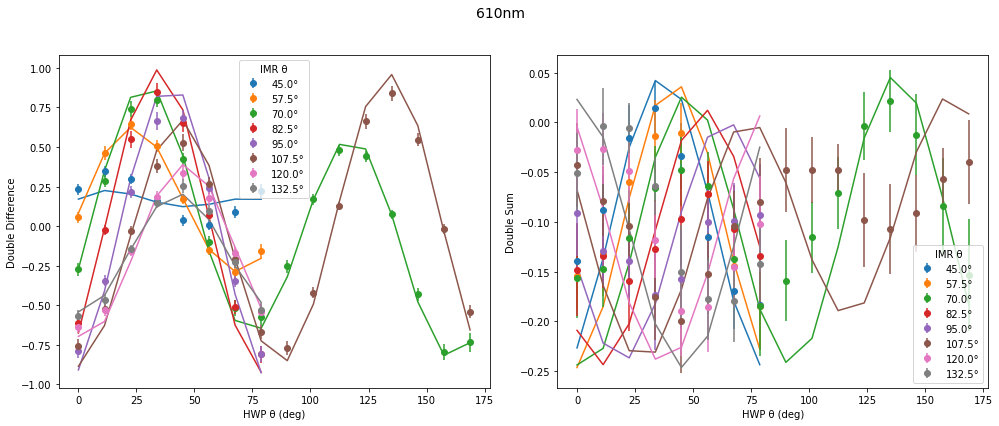

After p0: {'dichroic': {'phi': 0.1770955919949047, 'epsilon': 1.3937691071257632e-06, 'theta': -25.478265790289065}, 'flc': {'phi': 3.7699111843077517, 'delta_theta': -4.93913709367882}, 'optics': {'phi': 0.7233791458937813, 'epsilon': 0.016983281450160204, 'theta': -4.753512493324206}, 'image_rotator': {'phi': 1.3878065601091683}, 'hwp': {'phi': 2.847462192469986, 'delta_theta': 1.90380193433136}, 'lp': {'theta': -1.9766355433340426}}
Before p0: {'dichroic': {'phi': 0.1770955919949047, 'epsilon': 1.3937691071257632e-06, 'theta': -25.478265790289065}, 'flc': {'phi': 3.7699111843077517, 'delta_theta': -4.93913709367882}, 'optics': {'phi': 0.7233791458937813, 'epsilon': 0.016983281450160204, 'theta': -4.753512493324206}, 'image_rotator': {'phi': 1.3878065601091683}, 'hwp': {'phi': 2.847462192469986, 'delta_theta': 1.90380193433136}, 'lp': {'theta': -1.9766355433340426}}
Iteration #: 2
logl_value: 112.37262984590413
Best Fit Parameters: [ 9.15581344e-02  5.44515243e-06  2.91195812e+01  3.

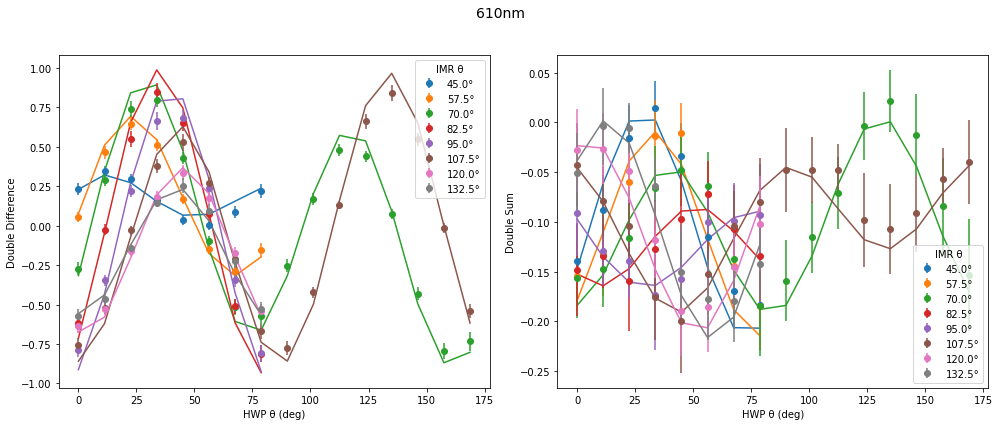

After p0: {'dichroic': {'phi': 0.09155813441252986, 'epsilon': 5.4451524288711876e-06, 'theta': 29.119581225996768}, 'flc': {'phi': 3.2384956779091745, 'delta_theta': -4.993337149919359}, 'optics': {'phi': 1.0578373456422918, 'epsilon': 0.014913083516365493, 'theta': 2.5947997686828126}, 'image_rotator': {'phi': 1.3980040177317097}, 'hwp': {'phi': 2.8128101248485358, 'delta_theta': 2.5218759055961026}, 'lp': {'theta': 2.453551915397883}}
Before p0: {'dichroic': {'phi': 0.09155813441252986, 'epsilon': 5.4451524288711876e-06, 'theta': 29.119581225996768}, 'flc': {'phi': 3.2384956779091745, 'delta_theta': -4.993337149919359}, 'optics': {'phi': 1.0578373456422918, 'epsilon': 0.014913083516365493, 'theta': 2.5947997686828126}, 'image_rotator': {'phi': 1.3980040177317097}, 'hwp': {'phi': 2.8128101248485358, 'delta_theta': 2.5218759055961026}, 'lp': {'theta': 2.453551915397883}}
Iteration #: 3
logl_value: 112.33719809065872
Best Fit Parameters: [ 1.69674325e-01  1.37979293e-05  6.32718516e+01

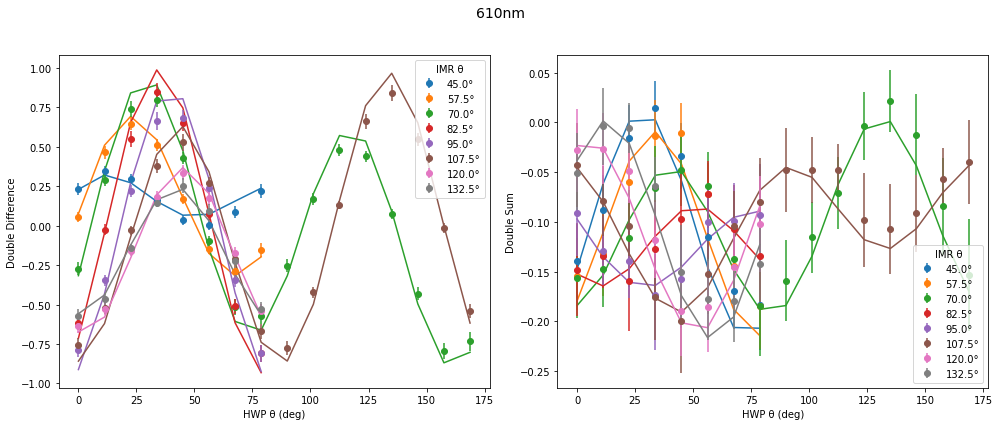

After p0: {'dichroic': {'phi': 0.16967432515688302, 'epsilon': 1.3797929262408816e-05, 'theta': 63.271851587871765}, 'flc': {'phi': 3.0953238747204157, 'delta_theta': -4.753896660445307}, 'optics': {'phi': 1.130622189028824, 'epsilon': 0.015316522355223884, 'theta': 4.423486203143442}, 'image_rotator': {'phi': 1.3978212373161143}, 'hwp': {'phi': 2.812610320796214, 'delta_theta': 2.516537569315399}, 'lp': {'theta': 2.453820758277935}}


In [6]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])
bounds_dict = {
    # "wollaston": {
    #     "transmission_ratio": (0.8, 1.2)
    # },
    "dichroic": {
        "phi": (-2 * np.pi, 2 * np.pi),
        "epsilon": (0, 1),
        "theta": (-90, 90)
    },
    "flc": {
        "phi": (0.4 * 2 * np.pi, 0.6 * 2 * np.pi),
        "delta_theta": (-5, 5)
    },
    "optics": {
        "phi": (-np.pi, np.pi),
        "epsilon": (0, 1),
        "theta": (-90, 90)
    },
    "image_rotator": {
        "phi": (
             (-2 * np.pi, 2 * np.pi)
        )
    },
    "hwp": {
        "phi": (
             (-2 * np.pi, 2 * np.pi)
        ),
        "delta_theta": (-5, 5)
    },
    "lp": {
        "theta": (-5, 5)
    }
}

# Now flatten the bounds in the same order as p0_keywords
for (comp, param), val in zip(p0_keywords, p0_values):
    lower, upper = bounds_dict[comp][param]
    if not (lower <= val <= upper):
        print(f"{comp}.{param} = {val} is outside bounds {lower} to {upper}")
bounds = [bounds_dict[comp][param] for comp, param in p0_keywords]

# Counters for iterative fitting
iteration = 1
previous_logl_value = 1000000
new_logl_value = 0

while abs(previous_logl_value - new_logl_value) > 0.01 * abs(previous_logl_value):
    print("Before p0: " + str(p0))
    if iteration > 1: 
        previous_logl_value = new_logl_value
    result, new_logl_value = inst.minimize_system_mueller_matrix(p0, system_mm, 
        interleaved_values, interleaved_stds, configuration_list, s_in = s_in,
        process_dataset = inst.process_dataset, 
        process_errors = inst.process_errors, 
        process_model = inst.process_model, bounds = bounds)
    
    # Print statements
    print("Iteration #: " + str(iteration))
    print("logl_value: " + str(new_logl_value))
    print("Best Fit Parameters: " + str(result.x))

    # Making a plot
    updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
    model = inst.model(result.x, p0_keywords, updated_system_mm, configuration_list, 
    process_model = inst.process_model)

    inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
        configuration_list, wavelength = wavelength_string)

    # Updating p0 for next time
    inst.update_p0(p0, result.x)
    print("After p0: " + str(p0))

    iteration += 1

    filename = f"{wavelength_string}_no_IMR_offset_or_HWP_and_IMR_constraints_fixed_EM_gain_with_dichroic_best_fit_old_fit_values.txt"
    with open(filename, 'w') as f:
        json.dump(p0, f, indent=4)

# Step 6: Plot model with best fit

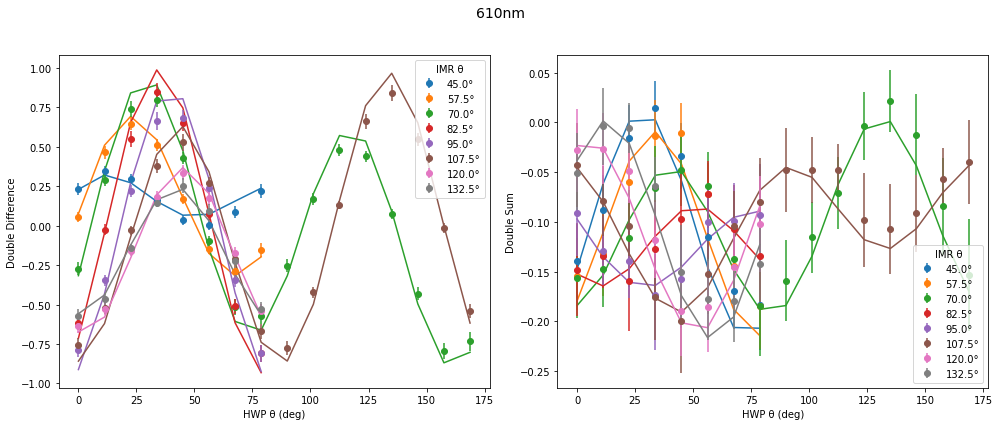

In [7]:
# Generate model with p0 keywords but scipy minimized results
# print(result.x)
# print(p0_keywords)

# Manually adjusting for a good fit
dichroic_phi = 0 # (waves)
dichroic_theta = 0 # (degrees)
# result.x = [2 * np.pi * dichroic_phi, dichroic_theta]

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)